In [13]:
import warnings;
warnings.simplefilter('ignore')

In [14]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from pathlib import Path

In [15]:
path_to_csv = Path(os.getcwd()).parent / 'datasets' / 'train.csv'
df = pd.read_csv(path_to_csv)

In [16]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [17]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
df = df[df['store'] == 1]
df = df[df['item'] == 1]


df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object
df['date'] += pd.DateOffset(years=7)

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2024-04-30'].reset_index(drop=False)
test_df = temp_df.loc['2024-05-01':].reset_index(drop=False)

train_df.head()


,date,store,item,sales,year,month,day,weekday
0,2020-01-01,1,1,13,2020,1,1,2
1,2020-01-02,1,1,11,2020,1,2,3
2,2020-01-03,1,1,14,2020,1,3,4
3,2020-01-04,1,1,13,2020,1,4,5
4,2020-01-05,1,1,10,2020,1,5,6


In [18]:
train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2020-01-01,1,1,13,2020,1,1,2
1,2020-01-02,1,1,11,2020,1,2,3
2,2020-01-03,1,1,14,2020,1,3,4
3,2020-01-04,1,1,13,2020,1,4,5
4,2020-01-05,1,1,10,2020,1,5,6


In [19]:
test_df.tail()

,date,store,item,sales,year,month,day,weekday
240,2024-12-27,1,1,14,2024,12,27,4
241,2024-12-28,1,1,19,2024,12,28,5
242,2024-12-29,1,1,15,2024,12,29,6
243,2024-12-30,1,1,27,2024,12,30,7
244,2024-12-31,1,1,23,2024,12,31,1


In [20]:
new_df = train_df[['date', 'sales']]
new_df.columns = ['ds', 'y']
new_df.head()

,ds,y
0,2020-01-01,13
1,2020-01-02,11
2,2020-01-03,14
3,2020-01-04,13
4,2020-01-05,10


In [21]:
m = Prophet(interval_width=0.95, daily_seasonality=True)
model = m.fit(new_df)

23:22:31 - cmdstanpy - INFO - Chain [1] start processing
23:22:32 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
future = m.make_future_dataframe(periods=244,freq='D')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,13.551063,-1.907920,16.476826,13.551063,13.551063,-6.599141,-6.599141,-6.599141,2.233712,...,-3.644763,-3.644763,-3.644763,-5.188091,-5.188091,-5.188091,0.0,0.0,0.0,6.951922
1,2020-01-02,13.556497,-0.696079,18.069270,13.556497,13.556497,-4.492389,-4.492389,-4.492389,2.233712,...,-1.550519,-1.550519,-1.550519,-5.175582,-5.175582,-5.175582,0.0,0.0,0.0,9.064108
2,2020-01-03,13.561931,1.165725,18.226237,13.561931,13.561931,-3.877131,-3.877131,-3.877131,2.233712,...,-0.930377,-0.930377,-0.930377,-5.180466,-5.180466,-5.180466,0.0,0.0,0.0,9.684800
3,2020-01-04,13.567365,1.573980,19.246483,13.567365,13.567365,-3.008416,-3.008416,-3.008416,2.233712,...,-0.040413,-0.040413,-0.040413,-5.201715,-5.201715,-5.201715,0.0,0.0,0.0,10.558949
4,2020-01-05,13.572799,3.019963,21.004134,13.572799,13.572799,-1.582790,-1.582790,-1.582790,2.233712,...,1.421291,1.421291,1.421291,-5.237793,-5.237793,-5.237793,0.0,0.0,0.0,11.990009


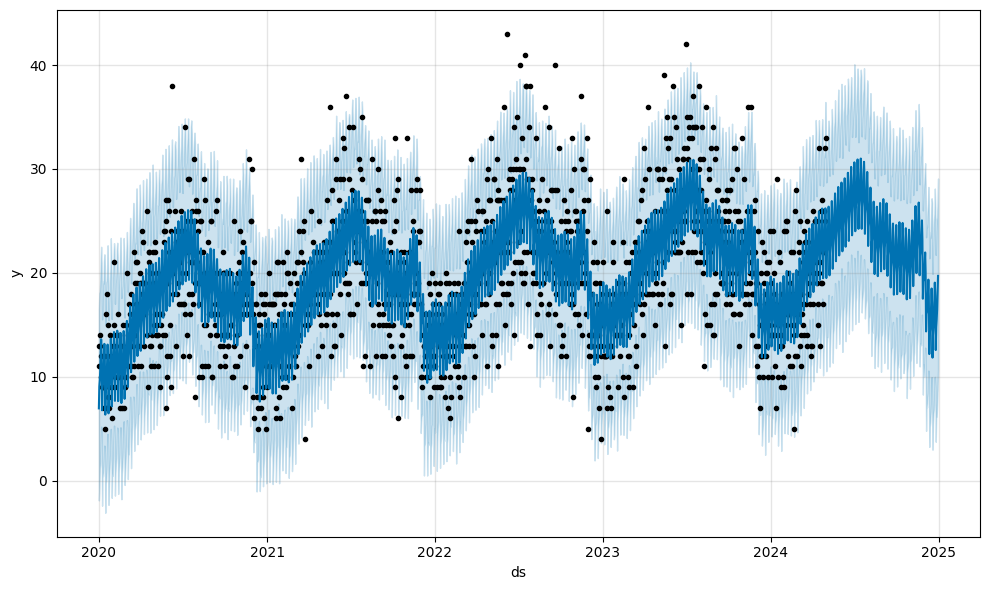

In [23]:
plot1 = m.plot(forecast)

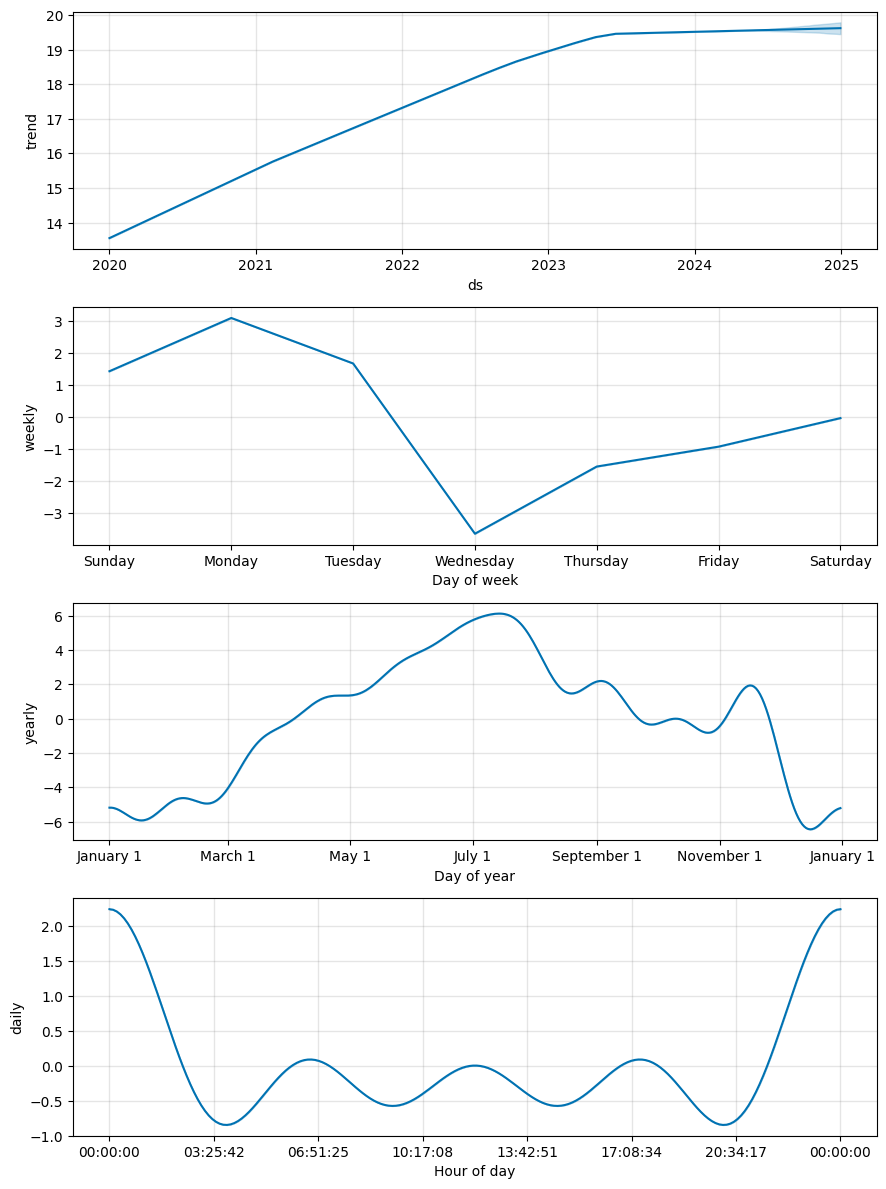

In [24]:
plt2 = m.plot_components(forecast)

In [25]:
pkl_path = Path(os.getcwd()) / 'model.pkl'
forecast_path = Path(os.getcwd()) / 'forecast.pkl'

with open(pkl_path, 'wb') as f:
    pickle.dump(m,f)

forecast.to_pickle(forecast_path)